### ***DIMINOS CASE STUDY***

In [89]:
#import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [91]:
#loading the dataset

df = pd.read_csv("C:/Users/HP/Documents/MISCELLANEOUS/Downloads/diminos_data.csv")

In [93]:
df

,order_id,order_placed_at,order_delivered_at
0,1523111,2023-03-01 00:00:59,2023-03-01 00:18:07.443132
1,1523112,2023-03-01 00:03:59,2023-03-01 00:19:34.925241
2,1523113,2023-03-01 00:07:22,2023-03-01 00:22:28.291385
3,1523114,2023-03-01 00:07:47,2023-03-01 00:46:19.019399
4,1523115,2023-03-01 00:09:03,2023-03-01 00:25:13.619056
...,...,...,...
14995,1538106,2023-03-27 23:37:05,2023-03-27 23:52:37.409378
14996,1538107,2023-03-27 23:47:38,2023-03-28 00:04:22.672912
14997,1538108,2023-03-27 23:50:16,2023-03-28 00:05:40.676238
14998,1538109,2023-03-27 23:52:44,2023-03-28 00:08:41.810358


In [95]:
df.shape

(15000, 3)

In [97]:
df.columns

Index(['order_id', 'order_placed_at', 'order_delivered_at'], dtype='object')

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   order_id            15000 non-null  int64 
 1   order_placed_at     15000 non-null  object
 2   order_delivered_at  15000 non-null  object
dtypes: int64(1), object(2)
memory usage: 351.7+ KB


In [101]:
## converting date-time columns to datetime format for time calculations

df['order_placed_at'] = pd.to_datetime(df['order_placed_at'])
df['order_delivered_at'] = pd.to_datetime(df['order_delivered_at'])

In [103]:
#calculating delivery duration in minutes

df['delivery_minutes'] = (
    df['order_delivered_at'] - df['order_placed_at']
).dt.total_seconds() / 60


In [105]:
df.head()

,order_id,order_placed_at,order_delivered_at,delivery_minutes
0,1523111,2023-03-01 00:00:59,2023-03-01 00:18:07.443132,17.140719
1,1523112,2023-03-01 00:03:59,2023-03-01 00:19:34.925241,15.598754
2,1523113,2023-03-01 00:07:22,2023-03-01 00:22:28.291385,15.104856
3,1523114,2023-03-01 00:07:47,2023-03-01 00:46:19.019399,38.533657
4,1523115,2023-03-01 00:09:03,2023-03-01 00:25:13.619056,16.176984


In [107]:
#removing invalid rows(negative or zero time)

df = df[df['delivery_minutes'] > 0]

In [109]:
df['delivery_minutes'].count()

15000

In [111]:
df.isnull().sum()

order_id              0
order_placed_at       0
order_delivered_at    0
delivery_minutes      0
dtype: int64

In [113]:
avg_time = df['delivery_minutes'].mean()
avg_time

20.499389326467778

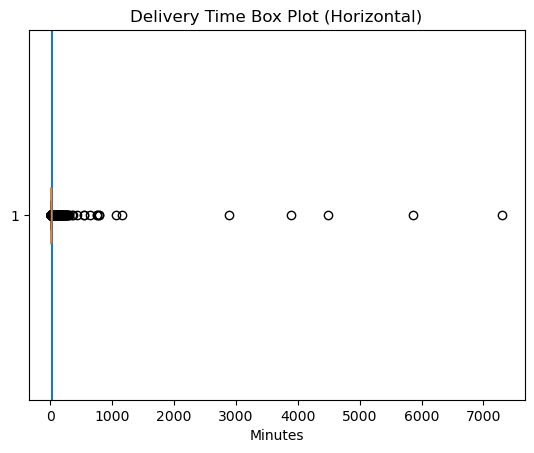

In [115]:
plt.figure()
plt.boxplot(df['delivery_minutes'], vert=False)
plt.axvline(31)
plt.title("Delivery Time Box Plot (Horizontal)")
plt.xlabel("Minutes")
plt.show()


The box plot shows that most deliveries are completed quickly, but a few extremely delayed orders appear as outliers. These outliers stretch the scale and heavily impact the 95th percentile, even though overall delivery performance is good.

In [117]:
## Calculates the 95th percentile of delivery time -- main KPI

p95 = df['delivery_minutes'].quantile(0.95)  


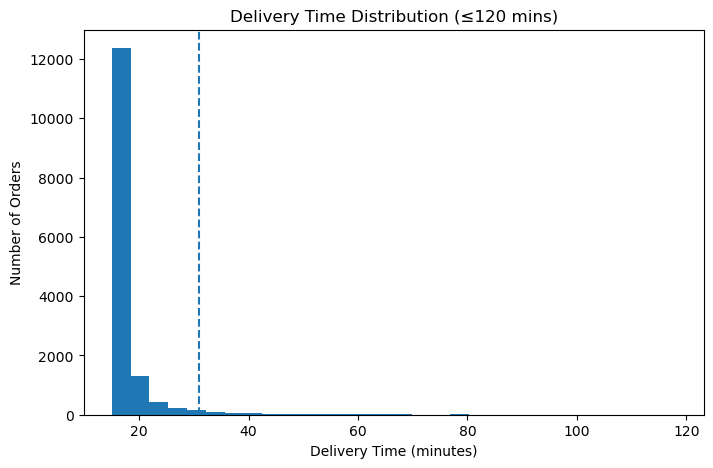

In [119]:
#removing extreme outliers

df_plot = df[df['delivery_minutes'] <= 120]

plt.figure(figsize=(8,5))
plt.hist(df_plot['delivery_minutes'], bins=30)
plt.axvline(31, linestyle='--')
plt.xlabel("Delivery Time (minutes)")
plt.ylabel("Number of Orders")
plt.title("Delivery Time Distribution (≤120 mins)")
plt.show()


In [121]:
#sla breach percentage

sla_breach_pct = (df['delivery_minutes'] > 31).mean() * 100
sla_breach_pct

3.713333333333333

In [123]:
print("Average delivery time:", avg_time)
print("95th percentile delivery time:", p95)
print("SLA breach percentage:", sla_breach_pct)


Average delivery time: 20.499389326467778
95th percentile delivery time: 27.261043996666658
SLA breach percentage: 3.713333333333333


From this, we can arrive at a conclusion only 3.71% of orders were delivered after 31 minutes

So the orders that are delivered within 31 mins = 96.29%

So SLA is met and Kanav is safe based on the metric.

In [125]:
df['hour'] = df['order_placed_at'].dt.hour
df['day'] = df['order_placed_at'].dt.day_name()

In [127]:
hourly_p95 = df.groupby('hour')['delivery_minutes'].quantile(0.95)
hourly_p95


hour
0     28.866990
1     32.104821
2     26.845717
3     25.617373
4     26.259762
5     23.924907
6     26.493076
7     27.154475
8     27.207707
9     25.709020
10    26.759252
11    33.407016
12    24.327900
13    29.714826
14    27.891228
15    24.933851
16    32.438371
17    28.260021
18    24.104592
19    26.801610
20    28.237978
21    28.932870
22    24.611743
23    26.943743
Name: delivery_minutes, dtype: float64

In [129]:
daily_p95 = df.groupby('day')['delivery_minutes'].quantile(0.95)
daily_p95


day
Friday       26.331713
Monday       28.737349
Saturday     26.935257
Sunday       26.517667
Thursday     26.534242
Tuesday      29.397539
Wednesday    26.442186
Name: delivery_minutes, dtype: float64

In [131]:
df_capped = df.copy()
df_capped['delivery_minutes'] = df_capped['delivery_minutes'].clip(upper=30)

df_capped['delivery_minutes'].quantile(0.95)


27.261043996666658

Throught the analysis, we can arrive at a conclusion that the store is having a good average performance and majority of the orders (96.29%) are delivered on time.A what-if analysis confirms that by controlling the worst-performing deliveries, the 95th percentile can be reduced to 27.26 minutes, ensuring compliance with Diminos’ performance standards. Therefore, targeted operational improvements focused on peak hours and delayed orders can successfully protect the franchise.